# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install vncorenlp
!pip install py_vncorenlp
!pip install unidecode
!pip install transformers
!pip install autokeras

## Library Setup

In [ ]:
import numpy as np
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Set up vncorelp to use in this assignment
import logging
from vncorenlp import VnCoreNLP
import py_vncorenlp

In [ ]:
!ls '/content/drive/MyDrive/IE304/scripts/'

abbreviations.py


In [ ]:
!cp '/content/drive/MyDrive/IE304/scripts/abbreviations.py' '/content/abbreviations.py'

In [ ]:
!ls

abbreviations.py  drive  models  sample_data  VnCoreNLP-1.2.jar


In [ ]:
# from abbreviations import Abb
import pandas as pd

class Abb():
    word = set()
    dic = dict()
    def __init__(self):
        df = pd.read_csv('/content/drive/MyDrive/IE304/example/Abbreviations.csv')
        for abb,nor in zip(df['Abbreviations'],df['Normalization']):
            ls = abb.split(',')
            for wor in ls:
                self.word.add(wor)
                self.dic[wor] = nor
    def rep(self,text):
        if text in self.word:
            return self.dic[text]
        else:
            return text

In [ ]:
#py_vncorenlp.download_model(save_dir='/content/drive/MyDrive/Sarcasm/vnNLP')
py_vncorenlp.download_model(save_dir='/content/')

# Load VnCoreNLP from the local working folder that contains both `VnCoreNLP-1.2.jar` and `models`
#model = py_vncorenlp.VnCoreNLP(save_dir='/content/drive/MyDrive/Sarcasm/vnNLP')
model_vncorenlp = py_vncorenlp.VnCoreNLP(save_dir='/content/')

VnCoreNLP model folder /content already exists! Please load VnCoreNLP from this folder!


#Load data

In [ ]:
link_data1 = '/content/drive/MyDrive/IE304/example/Dataset.csv'
link_data2 = '/content/drive/MyDrive/IE304/final_dataset/dataset_final_2.csv'
link_data_final = '/content/drive/MyDrive/IE304/merged_dataset.csv'
data = pd.read_csv(link_data_final)

In [ ]:
num_rows = len(data)
print("Số lượng dòng:", num_rows)

Số lượng dòng: 14803


##Xóa mẫu chưa gán nhãn

In [ ]:
index = data[data['Label'].isnull() == True].index
data.drop(index, inplace= True)

In [ ]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       14803 non-null  int64 
 1   Label    14803 non-null  int64 
 2   Comment  14803 non-null  object
dtypes: int64(2), object(1)
memory usage: 347.1+ KB


##Kiểm tra nhãn

In [ ]:
values = set()
data['Label'].apply(lambda x: values.add(x))
print(values)

{0, 1, 2}


# Preprocessing - Tiền xử lý dữ liệu




In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
import re

In [ ]:
#Đưa các từ lowercase
data['text'] = data['Comment'].str.lower()
#Loại bỏ dấu câu
character = ['\'','.',',','-',':','"','!','~','?',']','*']
character = set(character)

# Thay thế các dấu ngoặc bằng dấu cách
data['text'] = data['text'].str.replace(r"[\[\]\(\)\{\}]", " ", regex=True)

# Xóa các dấu cách thừa
data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

data['text'] = data['text'].apply(lambda x: ''.join([char for char in x if char not in character]))
data.head()

,Id,Label,Comment,text
0,1,0,"Slayder, GAM cần anh.",slayder gam cần anh
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè k chỉ nhảy qua tường sờ ty lè nhảy ph...
3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy e
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc mừng gam đã có kỳ chuyển nhượng thành công


##Giải nghĩa từ viết tắt

In [ ]:
abb = Abb()
data['text'] = data['text'].apply(lambda x: ''.join([abb.rep(char)+' ' for char in x.split()]))
data.head()

,Id,Label,Comment,text
0,1,0,"Slayder, GAM cần anh.",slayder gam cần anh
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè không chỉ nhảy qua tường sờ ty lè nhả...
3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy em
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc mừng gam đã có kỳ chuyển nhượng thành công


##Word segmentation

In [ ]:
#Thực hiện Word Segmentation bằng toolkit VNCoreLP
data['text'] = data['text'].apply(lambda x: " ".join(word for word in model_vncorenlp.word_segment(x)))

In [ ]:
data.reset_index(inplace = True)
data

,index,Id,Label,Comment,text
0,0,1,0,"Slayder, GAM cần anh.",slayder gam cần_anh
1,1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy em
4,4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...
14798,14798,10159,0,Tâm Tailor Phạm Trúc Giang,tâm tailor phạm trúc_giang
14799,14799,10189,0,"Hôm nay mình ra toà, Thẩm phán bảo: “Chào ca s...",hôm_nay mình ra toà thẩm_phán bảo “ chào ca_sĩ...
14800,14800,10191,0,"Hôm ra toà, Thẩm phán bảo: “Chào ca sĩ Đoàn Di...",hôm ra toà thẩm_phán bảo “ chào ca_sĩ đoàn di ...
14801,14801,10193,0,Done em BOM,done em bom


##Bỏ Stopword

In [ ]:
data_train = []

#Loại bỏ các stopword
link_vn_stopword = '/content/drive/MyDrive/IE304/vietnamese-stopwords.txt'
stop_words = set(line.strip() for line in open(link_vn_stopword))
for sentence in data['text']:
    sen_new = ""
    sen_temp = sentence.split()
    #print(sen_temp)
    for word in sen_temp:
        #print(word,'.')
        if (word not in stop_words):
            sen_new += word + " "
        #print()
    data_train.append(sen_new)

print ("Headlines after Preprocessing")
for i in range (0,20):
  print (f"{i+1}/",data_train[i])

Headlines after Preprocessing
1/ slayder gam cần_anh 
2/ gam sẵn sèng 
3/ sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy phát team 
4/ mê nhảy 
5/ chúc_mừng gam kỳ chuyển_nhượng thành_công 
6/ mê nhảy 
7/ chuẩn thoát pressing luônnn 
8/ ok chúc sơn thành công đường tiếp giờ thì hóng ad mới 
9/ gam đầu_tư đi cửa sân_bay 
10/ trận best gánh 
11/ thằng hankay out hài vãi lồn đôn huấn_luyện_viên tạm vị_trí analyst gam tuyển huấn_luyện_viên chả ảnh_hưởng 
12/ msi xong thank you vị_trí sty1e 
13/ đem shogun đem taki 2 đánh kết_hợp 
14/ thầy sty1e lck hướng_dẫn thằng peyz thằng guma đánh zeri 2 thằng đánh ngu 
15/ dũng phạm se gam giúp thoát pressing 
16/ nghi_thức hiến tế bắt_đầu 
17/ ôi cảm_động hoá_thân thành fan gam khứa hơi anti gam một_chút 
18/ kick ác nhường chỗ tướng_quân 
19/ tao đợi thank you kati mãi 
20/ mong sty1e 


In [ ]:
data['Comment'] = data_train
data

,index,Id,Label,Comment,text
0,0,1,0,slayder gam cần_anh,slayder gam cần_anh
1,1,2,0,gam sẵn sèng,dạ mỗi khi gam cần em luôn sẵn sèng
2,2,3,0,sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy ph...,sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,4,0,mê nhảy,mê cái cách anh này nhảy em
4,4,5,0,chúc_mừng gam kỳ chuyển_nhượng thành_công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...
14798,14798,10159,0,tâm tailor phạm trúc_giang,tâm tailor phạm trúc_giang
14799,14799,10189,0,hôm_nay thẩm_phán bảo “ chào ca_sĩ đoàn di băn...,hôm_nay mình ra toà thẩm_phán bảo “ chào ca_sĩ...
14800,14800,10191,0,hôm thẩm_phán bảo “ chào ca_sĩ đoàn di băng ”,hôm ra toà thẩm_phán bảo “ chào ca_sĩ đoàn di ...
14801,14801,10193,0,done bom,done em bom


# Data Visualization

### 1. Phân bố nhãn

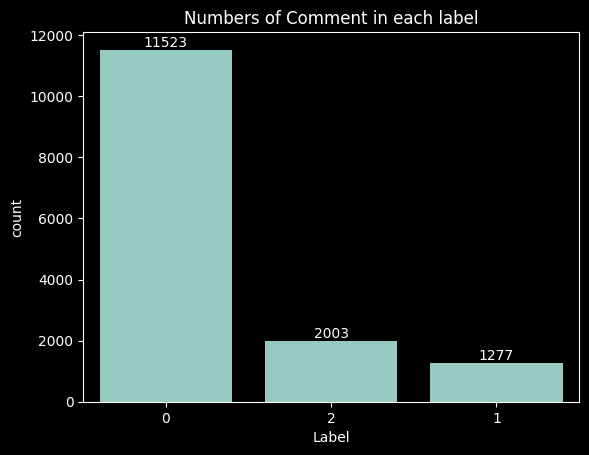

In [ ]:
label_name = ['0','1','2']
plt.style.use('dark_background')
ax = sns.countplot(x ="Label", data = data)
plt.xticks (ticks = data['Label'].unique(), labels=label_name)
ax.bar_label (ax.containers[0])
plt.title ("Numbers of Comment in each label")
plt.show ()

In [ ]:
#df = data[data['Label']==0]['Comment'].apply(len)
print ("Thống kê về độ dài của comment")
print("Độ dài trung bình của comment:",data['Comment'].apply(len).mean())

print ("Phân bố giá trị của comment: Min =",data['Comment'].apply(len).min(),", Max =",data['Comment'].apply(len).max())

print('-' * 55)
print ("Label 0")
print ("Miền giá trị độ dài: Min =",data[data['Label']==0]['Comment'].apply(len).min(),", Max =",data[data['Label']==0]['Comment'].apply(len).max())
print ("Độ dài trung bình của comment:",data[data['Label']==0]['Comment'].apply(len).mean())

print('-' * 55)
print ("Label 1")
print ("Miền giá trị độ dài: Min =",data[data['Label']==1]['Comment'].apply(len).min(),", Max =",data[data['Label']==0]['Comment'].apply(len).max())
print ("Độ dài trung bình của comment:",data[data['Label']==1]['Comment'].apply(len).mean())

print('-' * 55)
print ("Label 2")
print ("Miền giá trị độ dài: Min =",data[data['Label']==2]['Comment'].apply(len).min(),", Max =",data[data['Label']==0]['Comment'].apply(len).max())
print ("Độ dài trung bình của comment:",data[data['Label']==2]['Comment'].apply(len).mean())

Thống kê về độ dài của comment
Độ dài trung bình của comment: 33.46672971694927
Phân bố giá trị của comment: Min = 0 , Max = 238
-------------------------------------------------------
Label 0
Miền giá trị độ dài: Min = 0 , Max = 213
Độ dài trung bình của comment: 31.222858630564957
-------------------------------------------------------
Label 1
Miền giá trị độ dài: Min = 0 , Max = 213
Độ dài trung bình của comment: 37.088866699950074
-------------------------------------------------------
Label 2
Miền giá trị độ dài: Min = 0 , Max = 213
Độ dài trung bình của comment: 48.032889584964764


In [ ]:
data = data[data['Comment'].apply(len) > 0]
data.reset_index(inplace = True)
data

,level_0,index,Id,Label,Comment,text
0,0,0,1,0,slayder gam cần_anh,slayder gam cần_anh
1,1,1,2,0,gam sẵn sèng,dạ mỗi khi gam cần em luôn sẵn sèng
2,2,2,3,0,sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy ph...,sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,3,4,0,mê nhảy,mê cái cách anh này nhảy em
4,4,4,5,0,chúc_mừng gam kỳ chuyển_nhượng thành_công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...,...
14672,14798,14798,10159,0,tâm tailor phạm trúc_giang,tâm tailor phạm trúc_giang
14673,14799,14799,10189,0,hôm_nay thẩm_phán bảo “ chào ca_sĩ đoàn di băn...,hôm_nay mình ra toà thẩm_phán bảo “ chào ca_sĩ...
14674,14800,14800,10191,0,hôm thẩm_phán bảo “ chào ca_sĩ đoàn di băng ”,hôm ra toà thẩm_phán bảo “ chào ca_sĩ đoàn di ...
14675,14801,14801,10193,0,done bom,done em bom


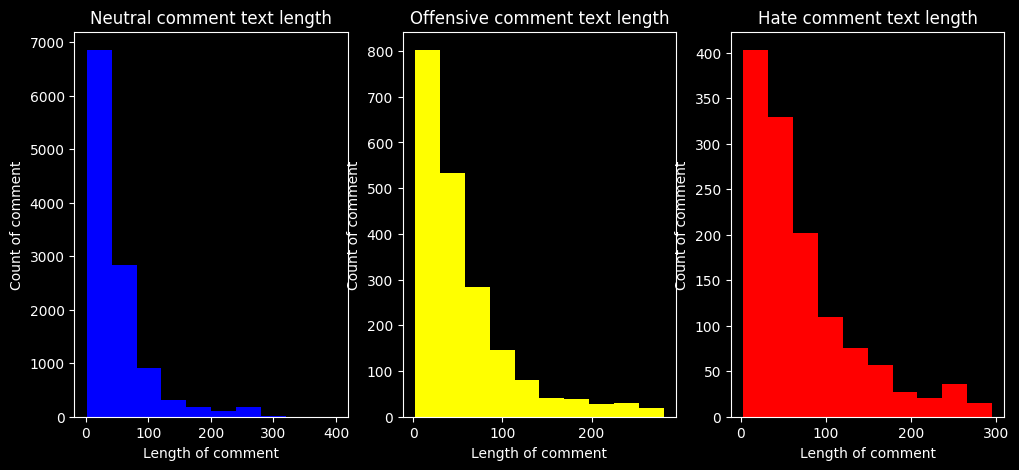

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,5))
plt.style.use('dark_background')
text_len=data[data['Label']==0]['text'].apply(len)
ax1.hist(text_len,color='blue')
ax1.set_xlabel('Length of comment')
ax1.set_ylabel('Count of comment')
ax1.set_title('Neutral comment text length')

text_len=data[data['Label']==1]['text'].apply(len)
ax2.hist(text_len,color='yellow')
ax2.set_xlabel('Length of comment')
ax2.set_ylabel('Count of comment')
ax2.set_title('Offensive comment text length')

text_len=data[data['Label']==2]['text'].apply(len)
ax3.hist(text_len,color='red')
ax3.set_xlabel('Length of comment')
ax3.set_ylabel('Count of comment')
ax3.set_title('Hate comment text length')

plt.show()

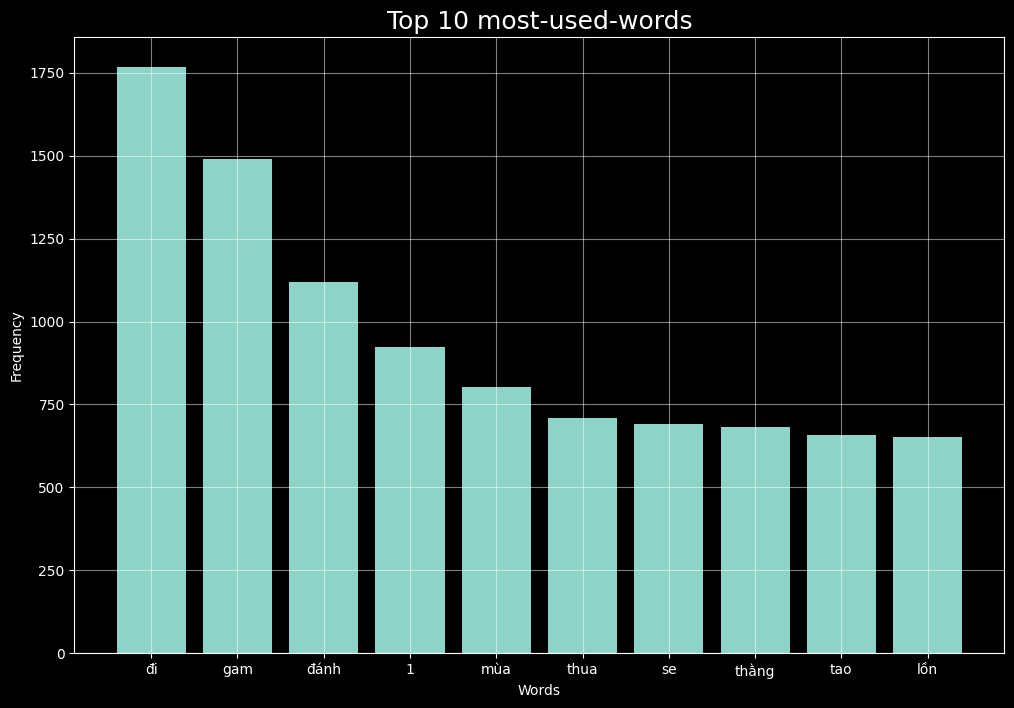

In [ ]:
words = []

for text in data_train:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))
plt.style.use('dark_background')
plt.figure(figsize = (12, 8))
plt.bar(range(len(top_words)), list(top_words.values()), align='center')
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.grid(alpha = 0.5)
plt.title('Top 10 most-used-words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

Text(0.5, 9.444444444444438, 'Token Count')

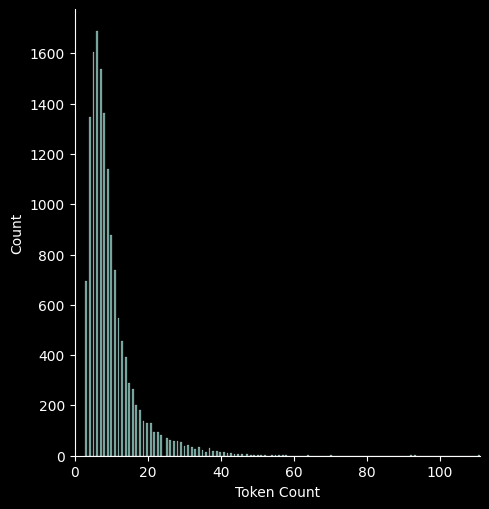

In [ ]:
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in data['Comment']]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

##Spliting Data - Thực hiện phân chia tập dữ liệu thành tập Train và tập Test

- Tỉ lệ giữa tập Train và Test là 80:20

In [ ]:
X = np.array(data['Comment'])
Y = np.array(data['Label'])

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.20, random_state = 0, shuffle = True)

In [ ]:
print ("Thống kê số lượng dữ liệu của tập Train và tập Test")

print ("Tập train")
print ("Kích thước tập Train:",xtrain.shape)
for i in range (len(label_name)):
    print(label_name[i],":",np.count_nonzero(ytrain==i))
print('-' * 55)
print ("Tập test")
print ("Kích thước tập Test:",xtest.shape)
for i in range(len(label_name)):
    print(label_name[i],":",np.count_nonzero(ytest==i))

Thống kê số lượng dữ liệu của tập Train và tập Test
Tập train
Kích thước tập Train: (11741,)
0 : 9125
1 : 1578
2 : 1038
-------------------------------------------------------
Tập test
Kích thước tập Test: (2936,)
0 : 2274
1 : 424
2 : 238


# Training


#PhoBert

In [ ]:
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

##Fine tuning

In [ ]:
class CommentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=30):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Comment']
        label = row['Label']
        return text, label

In [ ]:
class DistilXLMRClassifier(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained("microsoft/xtremedistil-l6-h384-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]  # lấy token [CLS]
        x = self.dropout(x)
        return self.classifier(x)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/xtremedistil-l6-h384-uncased")

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

##Load Model

In [ ]:
# model = CommentClassifier(n_classes = 3)
model = DistilXLMRClassifier(n_classes = 3)
model

DistilXLMRClassifier(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, el

##Tạo hàm train và val

In [ ]:
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    print('Start train')
    for data in tqdm(train_loader, desc="Training"):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    acc = correct.double() / len(train_loader.dataset)
    print(f'Train Accuracy: {acc:.4f} | Loss: {np.mean(losses):.4f}')


def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def prepare_loaders(df):
    df_train, df_test =  train_test_split(df, test_size = 0.20, random_state = 0, shuffle = True)
    df_train, df_valid = train_test_split(df_train, test_size = 0.125, random_state = 0, shuffle = True)
    train_dataset = CommentDataset(df_train, tokenizer, max_len=30)
    valid_dataset = CommentDataset(df_valid, tokenizer, max_len=30)
    test_dataset = CommentDataset(df_test, tokenizer, max_len=30)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

    return train_loader, valid_loader, test_loader

In [ ]:
best_acc = 0

##Bắt đầu train

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 1
model = model.to(device)

In [ ]:
train_loader, valid_loader,test_loader = prepare_loaders(data)

criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
optimizer = AdamW(model.parameters(), lr=2e-5)

lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader)*EPOCHS
        )
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    train(model, criterion, optimizer, train_loader)
    val_acc = eval()

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'xtremedistil.pth')
        best_acc = val_acc

Epoch 1/1
------------------------------
Start train


Training: 100%|██████████| 1285/1285 [15:34<00:00,  1.38it/s]

Train Accuracy: 0.7868 | Loss: 0.6166


Valid Accuracy: 0.803133514986376 Loss: 0.5771496808156371


##Pred && Eval

In [ ]:
y = []
y_ = []

train_loader, valid_loader,test_loader = prepare_loaders(data)
model.eval()
with torch.no_grad():
        data_loader = test_loader
        for dat in data_loader:
            input_ids = dat['input_ids'].to(device)
            attention_mask = dat['attention_masks'].to(device)
            targets = dat['targets'].to(device)
            for i in targets:
                y.append(i)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)
            for i in pred:
                y_.append(i)

            # loss = criterion(outputs, targets)
            # correct += torch.sum(pred == targets)
            # losses.append(loss.item())

In [ ]:
print(f"Accuracy: {accuracy_score(y,y_)}")
print(classification_report(y,y_))

Accuracy: 0.8113079019073569
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2274
           1       0.78      0.17      0.28       424
           2       0.46      0.41      0.44       238

    accuracy                           0.81      2936
   macro avg       0.70      0.52      0.54      2936
weighted avg       0.80      0.81      0.77      2936



In [ ]:
print(f"Accuracy DistilXLMR: {accuracy_score(y,y_)}")
print ("Precision:",precision_score(y,y_,average='macro'))
print ("Recall:",recall_score(y,y_,average='macro'))
print ("F1:",f1_score(y,y_,average='macro'))

Accuracy DistilXLMR: 0.8113079019073569
Precision: 0.6957233381768337
Recall: 0.5181037649622833
F1: 0.5390548555966375


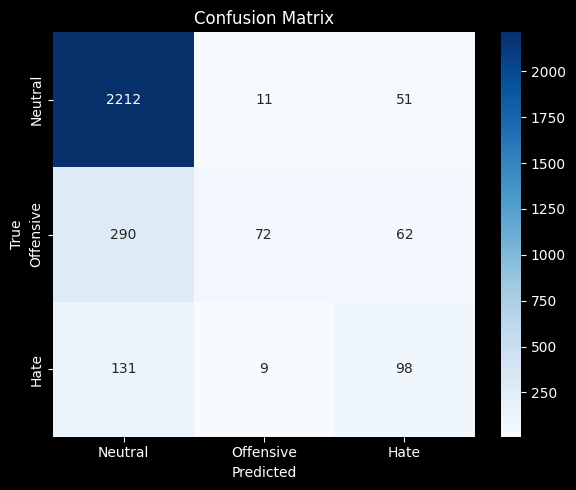

In [ ]:
# cf = confusion_matrix (y,y_)
# label_name = ['Neutral','Offenvise','Hate']
# sns.set(font_scale=1.)
# sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name, annot_kws={"size": 12},fmt='d')
# plt.title ("Confusion Matrix - Transfer Learning Model (Use PhoBERT)",fontsize=12)
# plt.xlabel('Predicted',fontsize=12)
# plt.ylabel('True',fontsize=12)
# plt.show()

y_true = y
y_pred = y_

cm = confusion_matrix(y_true, y_pred)
labels = ["Neutral", "Offensive", "Hate"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
sentence_difference = []
predict_label = []
true_label = []

for i in range(len(y_)):
    if y_[i] != y[i]:
        sentence_difference.append(xtest[i])
        true_label.append(y[i])
        predict_label.append(y_[i])

dict_df = {
    "Sentence": sentence_difference,
    "Predict": predict_label,
    "True": true_label
}

df_differ = pd.DataFrame(dict_df)
# df_differ.to_csv("/content/differ_in_predict.csv", index=False)

df_differ


,Sentence,Predict,True
0,bóc_lịch nằm_xuống không_thể bóc moi mấy nhẹ,tensor(0),tensor(2)
1,chè_xanh kích tú tuyển pót,tensor(2),tensor(1)
2,mùa se cút mất_ren 70%,tensor(2),tensor(0)
3,thắc_mắc liếm,tensor(2),tensor(1)
4,lòi lol,tensor(0),tensor(1)
...,...,...,...
549,thật_sự nể phục fan fan fan respect,tensor(0),tensor(1)
550,tương trụ hạng bày_đặt livestream,tensor(0),tensor(1)
551,vợ_chồng thánh nổ di băng quy_mô sản_xuất buôn...,tensor(0),tensor(1)
552,se tuyển content teka byt vĩnh_biệt cũ,tensor(0),tensor(1)


In [ ]:
df_differ.to_csv("differ_in_predict.csv", index=False)

#Load model đã train trước đó

In [ ]:
# model = CommentClassifier(n_classes = 3)
# model.load_state_dict(torch.load('phobert.pth'))

#Lưu model qua drive

In [ ]:
!cp  '/content/drive/MyDrive/IE304/phobert.pth' '/content/phobert.pth'

cp: cannot stat '/content/drive/MyDrive/IE304/phobert.pth': No such file or directory


In [ ]:
def predict_comment(text, model, tokenizer, max_len=128):
    import re
    import torch

    # Tiền xử lý văn bản
    text = text.lower()
    text = re.sub(r"[\[\]\(\)\{\}]", " ", text)
    text = re.sub(r"[\'\.\,\-\:\"!~\?\*\']", "", text)
    text = re.sub(r'\s+', ' ', text).strip()

    text = ' '.join([abb.rep(word) for word in text.split()])

    # Tokenize
    inputs = tokenizer.encode_plus(
        text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Dự đoán
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.squeeze().tolist()


In [ ]:
text = "vãi cả lồn má mày"
predicted_label, probabilities = predict_comment(text, model, tokenizer)

print("Label dự đoán:", predicted_label)
print("Xác suất:", probabilities)


Label dự đoán: 2
Xác suất: [0.120551198720932, 0.34810328483581543, 0.531345546245575]
